In [1]:
import json
import os

import tensorrt
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2023-11-14 01:19:44.632474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-11-14 01:19:46.767355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:46.775273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:46.775621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Visualize
Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to visualize some examples from the MNIST dataset of handwritten digits

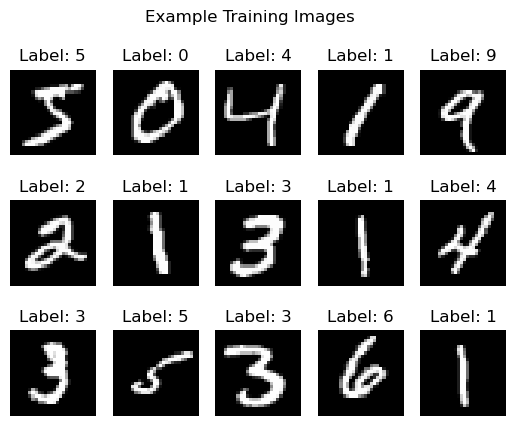

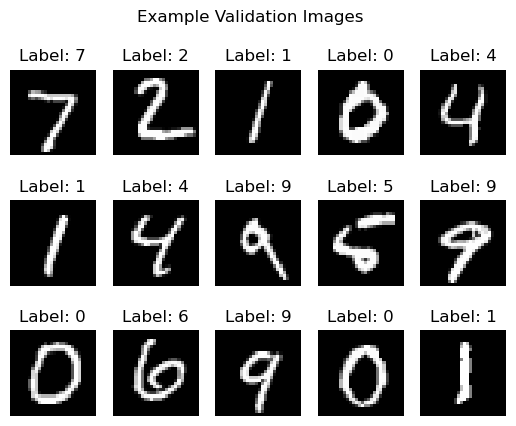

In [3]:
train, val = mnist.load_data()
nrow, ncol = 3, 5

for data, label, kind in [(*train, 'Training'), (*val, 'Validation')]:
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            plt.subplot(nrow, ncol, idx + 1)
            plt.axis('off')
            plt.imshow(data[idx], cmap='gray')
            plt.title(f'Label: {label[idx]}')

    plt.suptitle(f'Example {kind} Images')
    plt.savefig(f'{kind.lower()}_example.png')
    plt.show()

## Parameters

In [4]:
FILE_PREFIX = 'dense_arch1'   # The model is saved in a file with the provided prefix under the folder icon on the left
DENSE_NET = True              # True trains a dense NN, False trains a convolutional NN
REGULARIZATION = 0.00         # l2 regularization strength

## Train
Author: Aadyot Bhatnagar

Last modified: April 19, 2022

Description: A script to train and save a neural net to recognize the MNIST dataset of handwritten digits. Supports both a standard dense network and a convolutional network.

In [5]:
## Return MNIST dataset, shaped appropriately depending on whether we are
## want to train a dense or convolutional neural net
def get_data(is_net_conv):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize input images to have all values in [0, 1]
    # Reshape image dataset to have shape (N, H, W, C) instead of (N, H, W)
    if is_net_conv:
        X_train = X_train.reshape((*(X_train.shape), 1)) / 255
        X_test = X_test.reshape((*(X_test.shape), 1)) / 255

    # Normalize input images to have all values in [0, 1]
    # Flatten image dataset to have shape (N, H * W) instead of (N, H, W)
    else:
        X_train = X_train.reshape((X_train.shape[0], -1)) / 255
        X_test = X_test.reshape((X_test.shape[0], -1)) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


## Construct a dense neural net and return it
def build_dense_net(reg_param, *, n1=200, n2=100, activation='relu'):
    model = Sequential()
    model.add(Dense(n1, input_shape=(784,), kernel_regularizer=l2(reg_param)))
    model.add(Activation(activation))
    model.add(Dense(n2, kernel_regularizer=l2(reg_param)))
    model.add(Activation(activation))
    model.add(Dense(10, kernel_regularizer=l2(reg_param)))
    model.add(Activation('softmax'))
    return model


## Construct a convolutional neural net and return it
def build_conv_net(reg_param):
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding='same',
                     input_shape=(28, 28, 1),
                     kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(10, (3, 3), padding='same', 
                     kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Need to flatten tensor output from conv layer to vector for dense layer
    model.add(Flatten())
    model.add(Dense(10, kernel_regularizer=l2(reg_param)))
    model.add(Activation('softmax'))

    return model


def main(model_name, dense_net=True, regularization=0.00, *, n1=200, n2=100, activation="relu", path="", save=True):
    """
    Trains a NN to recognize handwritten digits.

    file_prefix - prefix for file to save trained model to (e.g. dense_arch1, conv_regularize05, etc.)
    dense_net - whether to train a dense NN or a convolutional NN (defaults to dense NN)
    regularization - strength of l2 regularization to use (defaults to no regularization)
    """

    file_prefix = model_name
    if path:
        file_prefix = f"{model_name}_{n1=}_{n2=}"
        if regularization:
            file_prefix += f"_L={regularization:.0e}"
        if activation != "relu":
            file_prefix += f"_{activation}"

    # Importing the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = get_data(not dense_net)
    model = build_dense_net(regularization, n1=n1, n2=n2, activation=activation) if dense_net \
            else build_conv_net(regularization)

    # Print a summary of the layers and weights in the model
    model.summary()

    # Have our model minimize the categorical cross entropy loss with the adam
    # optimizer (fancier stochastic gradient descent that converges faster)
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1,
                        validation_data=(X_test, y_test))

    if save:
        cwd = os.getcwd()

        # Create img directory to save images if needed
        os.makedirs(os.path.join(cwd, path, 'img'), exist_ok=True)
        plot_fname = os.path.join(cwd, path, 'img', f'{file_prefix}_learn.png')

        # Create model directory to save models if needed
        os.makedirs(os.path.join(cwd, path, 'model'), exist_ok=True)
        model_weights_fname = os.path.join(cwd, path, 'model', f'{file_prefix}.h5')
        model_json_fname = os.path.join(cwd, path, 'model', f'{file_prefix}.json')
        
        # Save model weights and json spec describing the model's architecture
        model.save(model_weights_fname)
        with open(model_json_fname, 'w') as f:
            f.write(json.dumps(json.loads(model.to_json()), indent=4))

    # Plot accuracy learning curve
    _, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='lower right')

    # Plot loss learning curve
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper right')

    if path:
        legend = ""
        if n1 != 200 or n2 != 100:
            legend += f"d_1={n1},\,d_2={n2}"
        if regularization:
            if len(legend):
                legend += ",\,"
            legend += f"\lambda=10^{{{np.log10(regularization):.0f}}}"
        print(legend)
        axs[0].set_ylim((0.8, 1))
        axs[1].set_ylim((0, 2 / 3))
        axs[0].text(-2, 1.03, f"${legend}$" if legend else "")
    plt.tight_layout()
    if save:
        plt.savefig(plot_fname)
    plt.show()

    return model, history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               157000    
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17811

2023-11-14 01:19:48.612737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:48.612999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:48.613633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:49.249545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 01:19:49.249762: I tensorflow/compile

Epoch 1/10


2023-11-14 01:19:52.841945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 01:19:52.847066: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a3be289d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 01:19:52.847101: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-14 01:19:52.851807: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 01:19:54.399569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-11-14 01:19:54.584578: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 01:19:54.62636

469/469 [==============================] - 7s 7ms/step - loss: 0.2958 - accuracy: 0.9167 - val_loss: 0.1423 - val_accuracy: 0.9579
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1159 - accuracy: 0.9655 - val_loss: 0.1057 - val_accuracy: 0.9683
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0776 - accuracy: 0.9771 - val_loss: 0.0870 - val_accuracy: 0.9728
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0573 - accuracy: 0.9826 - val_loss: 0.0809 - val_accuracy: 0.9751
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0445 - accuracy: 0.9860 - val_loss: 0.0742 - val_accuracy: 0.9763
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0870 - val_accuracy: 0.9745
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 0.0712 - val_accuracy: 0.9785
Epoch 8/10
469/46

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


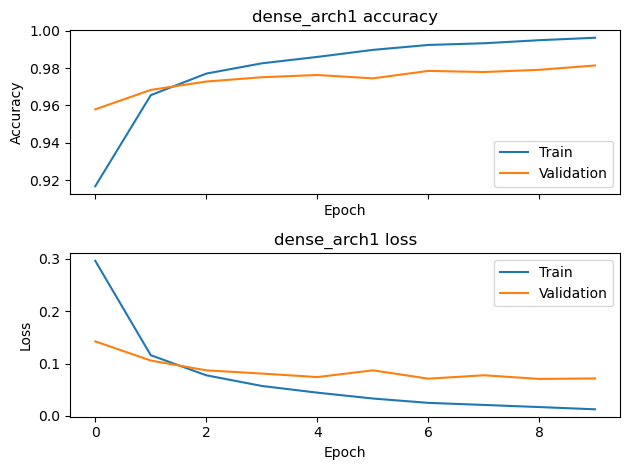

(<keras.src.engine.sequential.Sequential at 0x7f291143f490>,
 <keras.src.callbacks.History at 0x7f2910de8a10>)

In [6]:
main(FILE_PREFIX, DENSE_NET, REGULARIZATION)

## 1 Classifying digits with NNs

In [7]:
mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

### 1.3 Number of Parameters

Author: Benjamin Ye

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                19625     
                                                                 
 activation_3 (Activation)   (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 activation_4 (Activation)   (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 20535 (80.21 KB)
Trainable params: 20535

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


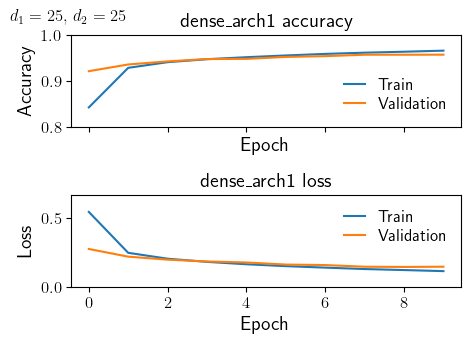

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25)                19625     
                                                                 
 activation_6 (Activation)   (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 50)                1300      
                                                                 
 activation_7 (Activation)   (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                510       
                                                                 
 activation_8 (Activation)   (None, 10)                0         
                                                                 
Total params: 21435 (83.73 KB)
Trainable params: 21435

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


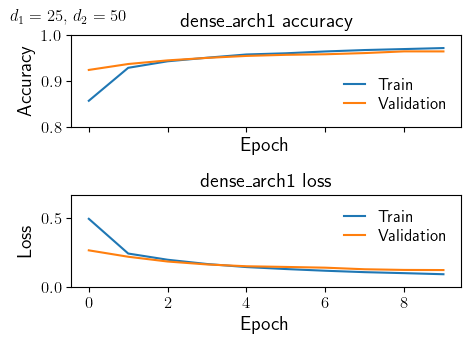

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 25)                19625     
                                                                 
 activation_9 (Activation)   (None, 25)                0         
                                                                 
 dense_10 (Dense)            (None, 100)               2600      
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
 activation_11 (Activation)  (None, 10)                0         
                                                                 
Total params: 23235 (90.76 KB)
Trainable params: 23235

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


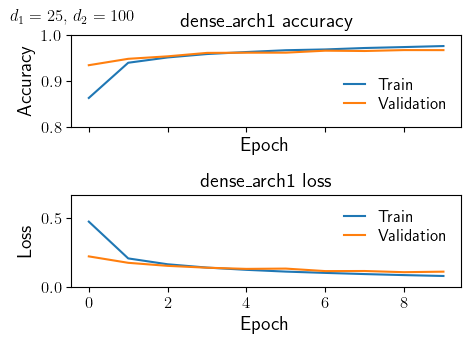

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 25)                19625     
                                                                 
 activation_12 (Activation)  (None, 25)                0         
                                                                 
 dense_13 (Dense)            (None, 200)               5200      
                                                                 
 activation_13 (Activation)  (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                2010      
                                                                 
 activation_14 (Activation)  (None, 10)                0         
                                                                 
Total params: 26835 (104.82 KB)
Trainable params: 2683

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


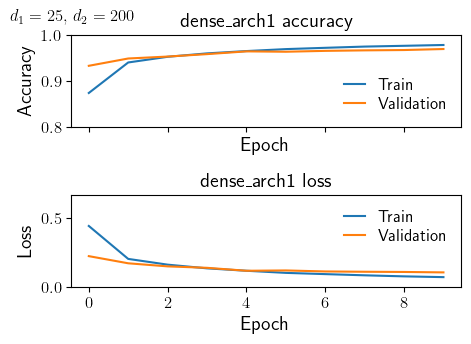

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                39250     
                                                                 
 activation_15 (Activation)  (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 25)                1275      
                                                                 
 activation_16 (Activation)  (None, 25)                0         
                                                                 
 dense_17 (Dense)            (None, 10)                260       
                                                                 
 activation_17 (Activation)  (None, 10)                0         
                                                                 
Total params: 40785 (159.32 KB)
Trainable params: 4078

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


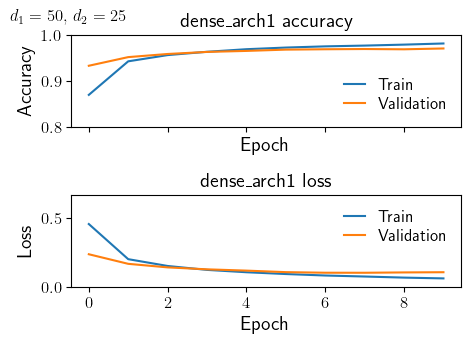

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 50)                39250     
                                                                 
 activation_18 (Activation)  (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 50)                2550      
                                                                 
 activation_19 (Activation)  (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 10)                510       
                                                                 
 activation_20 (Activation)  (None, 10)                0         
                                                                 
Total params: 42310 (165.27 KB)
Trainable params: 4231

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


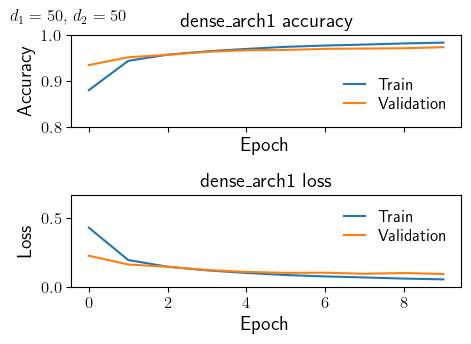

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                39250     
                                                                 
 activation_21 (Activation)  (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 100)               5100      
                                                                 
 activation_22 (Activation)  (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 10)                1010      
                                                                 
 activation_23 (Activation)  (None, 10)                0         
                                                                 
Total params: 45360 (177.19 KB)
Trainable params: 4536

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


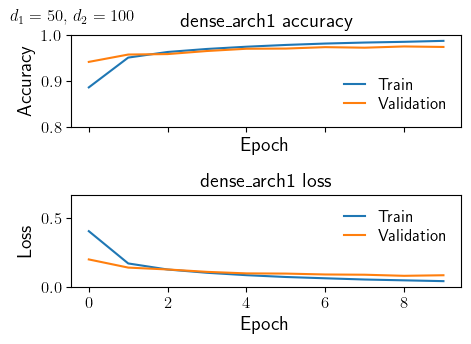

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 50)                39250     
                                                                 
 activation_24 (Activation)  (None, 50)                0         
                                                                 
 dense_25 (Dense)            (None, 200)               10200     
                                                                 
 activation_25 (Activation)  (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                2010      
                                                                 
 activation_26 (Activation)  (None, 10)                0         
                                                                 
Total params: 51460 (201.02 KB)
Trainable params: 5146

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


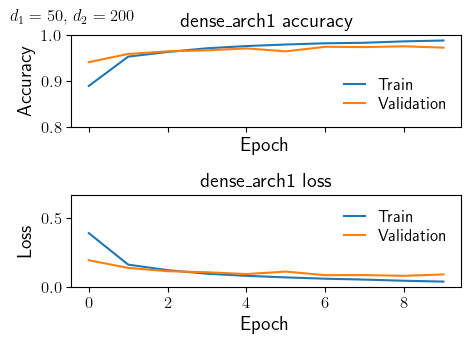

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 100)               78500     
                                                                 
 activation_27 (Activation)  (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 25)                2525      
                                                                 
 activation_28 (Activation)  (None, 25)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                260       
                                                                 
 activation_29 (Activation)  (None, 10)                0         
                                                                 
Total params: 81285 (317.52 KB)
Trainable params: 8128

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


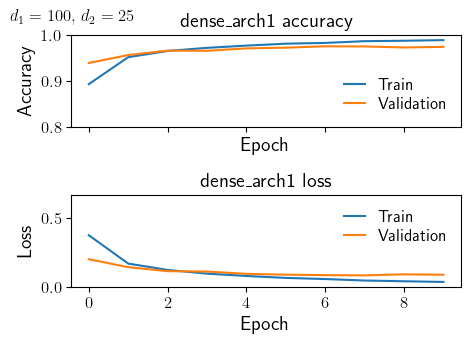

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               78500     
                                                                 
 activation_30 (Activation)  (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 50)                5050      
                                                                 
 activation_31 (Activation)  (None, 50)                0         
                                                                 
 dense_32 (Dense)            (None, 10)                510       
                                                                 
 activation_32 (Activation)  (None, 10)                0         
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 840

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


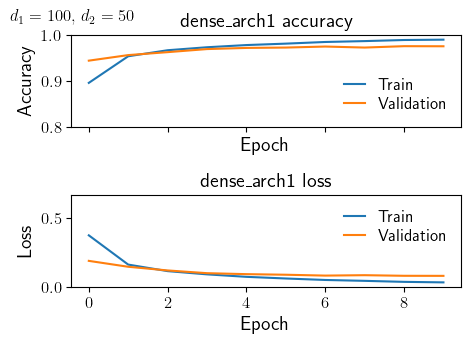

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 100)               78500     
                                                                 
 activation_33 (Activation)  (None, 100)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 activation_34 (Activation)  (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 10)                1010      
                                                                 
 activation_35 (Activation)  (None, 10)                0         
                                                                 
Total params: 89610 (350.04 KB)
Trainable params: 896

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


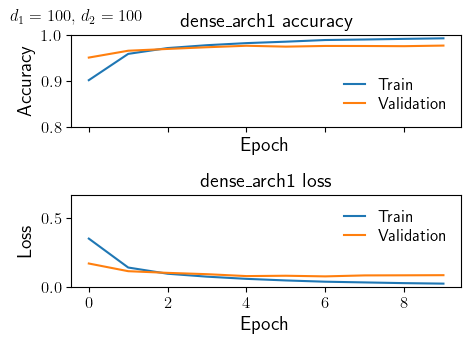

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               78500     
                                                                 
 activation_36 (Activation)  (None, 100)               0         
                                                                 
 dense_37 (Dense)            (None, 200)               20200     
                                                                 
 activation_37 (Activation)  (None, 200)               0         
                                                                 
 dense_38 (Dense)            (None, 10)                2010      
                                                                 
 activation_38 (Activation)  (None, 10)                0         
                                                                 
Total params: 100710 (393.40 KB)
Trainable params: 10

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


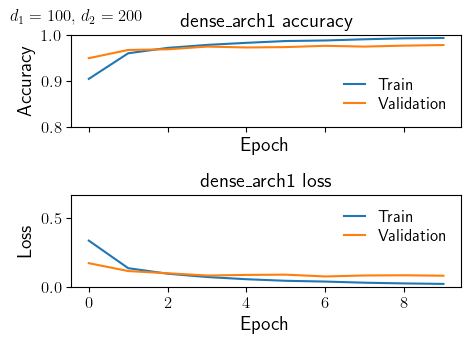

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 200)               157000    
                                                                 
 activation_39 (Activation)  (None, 200)               0         
                                                                 
 dense_40 (Dense)            (None, 25)                5025      
                                                                 
 activation_40 (Activation)  (None, 25)                0         
                                                                 
 dense_41 (Dense)            (None, 10)                260       
                                                                 
 activation_41 (Activation)  (None, 10)                0         
                                                                 
Total params: 162285 (633.93 KB)
Trainable params: 16

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


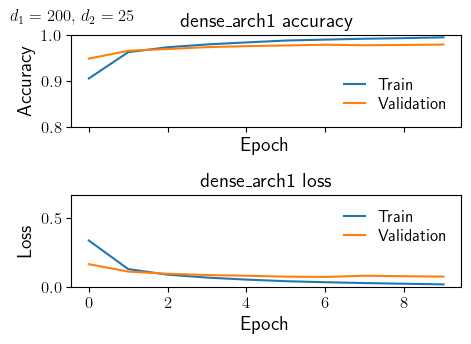

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 200)               157000    
                                                                 
 activation_42 (Activation)  (None, 200)               0         
                                                                 
 dense_43 (Dense)            (None, 50)                10050     
                                                                 
 activation_43 (Activation)  (None, 50)                0         
                                                                 
 dense_44 (Dense)            (None, 10)                510       
                                                                 
 activation_44 (Activation)  (None, 10)                0         
                                                                 
Total params: 167560 (654.53 KB)
Trainable params: 16

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


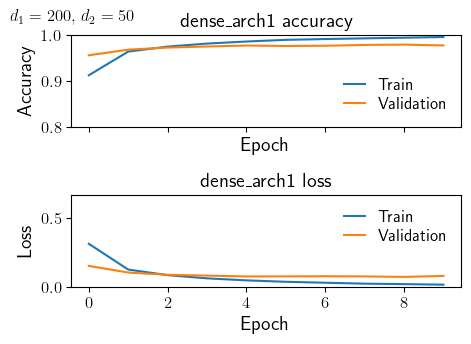

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 200)               157000    
                                                                 
 activation_45 (Activation)  (None, 200)               0         
                                                                 
 dense_46 (Dense)            (None, 100)               20100     
                                                                 
 activation_46 (Activation)  (None, 100)               0         
                                                                 
 dense_47 (Dense)            (None, 10)                1010      
                                                                 
 activation_47 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


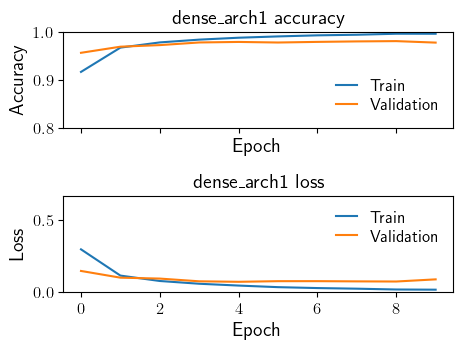

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 200)               157000    
                                                                 
 activation_48 (Activation)  (None, 200)               0         
                                                                 
 dense_49 (Dense)            (None, 200)               40200     
                                                                 
 activation_49 (Activation)  (None, 200)               0         
                                                                 
 dense_50 (Dense)            (None, 10)                2010      
                                                                 
 activation_50 (Activation)  (None, 10)                0         
                                                                 
Total params: 199210 (778.16 KB)
Trainable params: 19

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


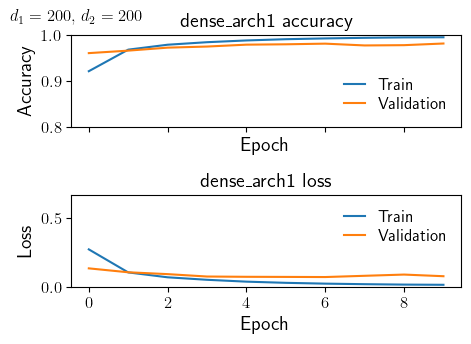

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 400)               314000    
                                                                 
 activation_51 (Activation)  (None, 400)               0         
                                                                 
 dense_52 (Dense)            (None, 25)                10025     
                                                                 
 activation_52 (Activation)  (None, 25)                0         
                                                                 
 dense_53 (Dense)            (None, 10)                260       
                                                                 
 activation_53 (Activation)  (None, 10)                0         
                                                                 
Total params: 324285 (1.24 MB)
Trainable params: 3242

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


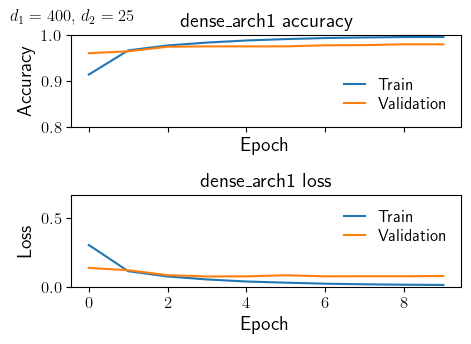

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 400)               314000    
                                                                 
 activation_54 (Activation)  (None, 400)               0         
                                                                 
 dense_55 (Dense)            (None, 50)                20050     
                                                                 
 activation_55 (Activation)  (None, 50)                0         
                                                                 
 dense_56 (Dense)            (None, 10)                510       
                                                                 
 activation_56 (Activation)  (None, 10)                0         
                                                                 
Total params: 334560 (1.28 MB)
Trainable params: 3345

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


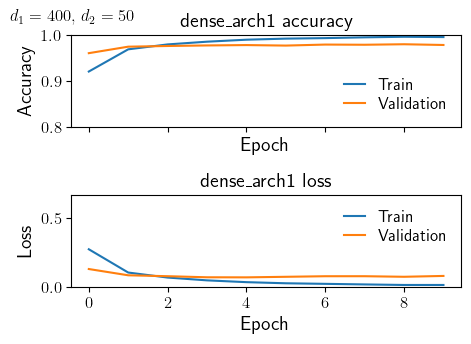

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 400)               314000    
                                                                 
 activation_57 (Activation)  (None, 400)               0         
                                                                 
 dense_58 (Dense)            (None, 100)               40100     
                                                                 
 activation_58 (Activation)  (None, 100)               0         
                                                                 
 dense_59 (Dense)            (None, 10)                1010      
                                                                 
 activation_59 (Activation)  (None, 10)                0         
                                                                 
Total params: 355110 (1.35 MB)
Trainable params: 3551

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


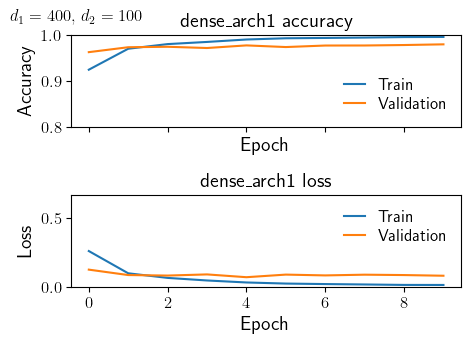

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 400)               314000    
                                                                 
 activation_60 (Activation)  (None, 400)               0         
                                                                 
 dense_61 (Dense)            (None, 200)               80200     
                                                                 
 activation_61 (Activation)  (None, 200)               0         
                                                                 
 dense_62 (Dense)            (None, 10)                2010      
                                                                 
 activation_62 (Activation)  (None, 10)                0         
                                                                 
Total params: 396210 (1.51 MB)
Trainable params: 3962

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


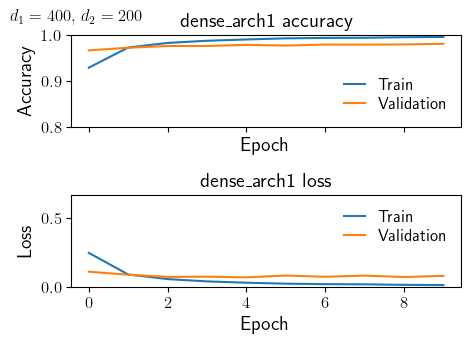

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 47)                36895     
                                                                 
 activation_63 (Activation)  (None, 47)                0         
                                                                 
 dense_64 (Dense)            (None, 25)                1200      
                                                                 
 activation_64 (Activation)  (None, 25)                0         
                                                                 
 dense_65 (Dense)            (None, 10)                260       
                                                                 
 activation_65 (Activation)  (None, 10)                0         
                                                                 
Total params: 38355 (149.82 KB)
Trainable params: 383

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


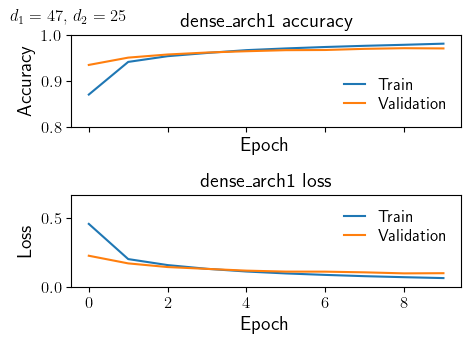

In [8]:
model_name = 'dense_arch1'
cwd = os.getcwd()

if os.path.isfile(os.path.join(cwd, 'exercise/1.3', f'{model_name}_stats.pkl')):
    df = pd.read_pickle(os.path.join(cwd, 'exercise/1.3', f'{model_name}_stats.pkl'))
else:
    cols = {'n1': int, 'n2': int, 'n_params': int, 'train_accuracy': float,
            'train_loss': float, 'validation_accuracy': float, 
            'validation_loss': float}
    df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in cols.items()})

    for n1 in (25, 50, 100, 200, 400):
        for n2 in (25, 50, 100, 200):
            model, history = main(model_name, n1=n1, n2=n2, path='exercise/1.3')
            df.loc[len(df)] = [
                n1, n2, 
                sum(K.count_params(p) for p in model.trainable_weights)
                + sum(K.count_params(p) for p in model.non_trainable_weights),
                history.history['accuracy'][-1], 
                history.history['loss'][-1],
                history.history['val_accuracy'][-1], 
                history.history['val_loss'][-1]
            ]

    model, history = main(model_name, n1=47, n2=25, path='exercise/1.3')
    df.loc[len(df)] = [
        n1, n2, 
        sum(K.count_params(p) for p in model.trainable_weights)
        + sum(K.count_params(p) for p in model.non_trainable_weights),
        history.history['accuracy'][-1], 
        history.history['loss'][-1],
        history.history['val_accuracy'][-1], 
        history.history['val_loss'][-1]
    ]
    df.to_pickle(os.path.join(cwd, 'exercise/1.3', f'{model_name}_stats.pkl'))

In [9]:
df

,n1,n2,n_params,train_accuracy,train_loss,validation_accuracy,validation_loss
0,25.0,25.0,20535.0,0.966167,0.113337,0.9574,0.145337
1,25.0,50.0,21435.0,0.971800,0.090740,0.9645,0.121027
2,25.0,100.0,23235.0,0.976183,0.078016,0.9673,0.109379
3,25.0,200.0,26835.0,0.978483,0.069694,0.9697,0.104111
4,50.0,25.0,40785.0,0.981767,0.060485,0.9709,0.105360
5,50.0,50.0,42310.0,0.983600,0.053474,0.9736,0.092431
6,50.0,100.0,45360.0,0.987467,0.040622,0.9742,0.083409
7,50.0,200.0,51460.0,0.988217,0.037395,0.9727,0.089204
8,100.0,25.0,81285.0,0.989050,0.034892,0.9744,0.086867
9,100.0,50.0,84060.0,0.990067,0.031661,0.9757,0.078931


### 1.4 Regularization

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 200)               157000    
                                                                 
 activation_66 (Activation)  (None, 200)               0         
                                                                 
 dense_67 (Dense)            (None, 100)               20100     
                                                                 
 activation_67 (Activation)  (None, 100)               0         
                                                                 
 dense_68 (Dense)            (None, 10)                1010      
                                                                 
 activation_68 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


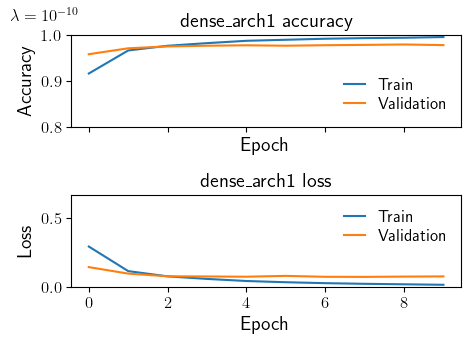

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 200)               157000    
                                                                 
 activation_69 (Activation)  (None, 200)               0         
                                                                 
 dense_70 (Dense)            (None, 100)               20100     
                                                                 
 activation_70 (Activation)  (None, 100)               0         
                                                                 
 dense_71 (Dense)            (None, 10)                1010      
                                                                 
 activation_71 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


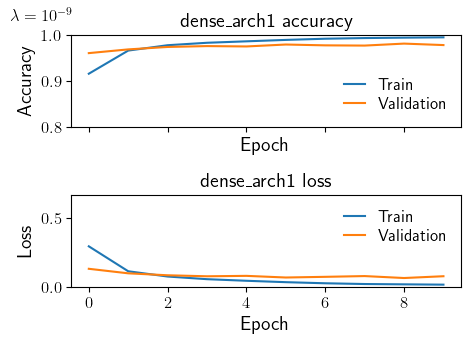

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 200)               157000    
                                                                 
 activation_72 (Activation)  (None, 200)               0         
                                                                 
 dense_73 (Dense)            (None, 100)               20100     
                                                                 
 activation_73 (Activation)  (None, 100)               0         
                                                                 
 dense_74 (Dense)            (None, 10)                1010      
                                                                 
 activation_74 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


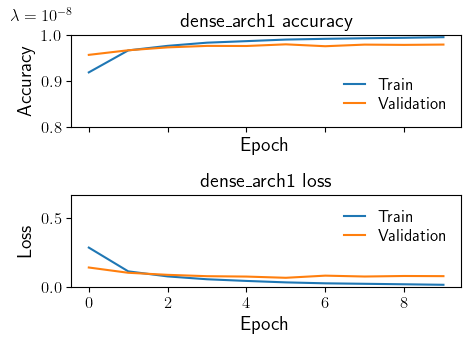

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 200)               157000    
                                                                 
 activation_75 (Activation)  (None, 200)               0         
                                                                 
 dense_76 (Dense)            (None, 100)               20100     
                                                                 
 activation_76 (Activation)  (None, 100)               0         
                                                                 
 dense_77 (Dense)            (None, 10)                1010      
                                                                 
 activation_77 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


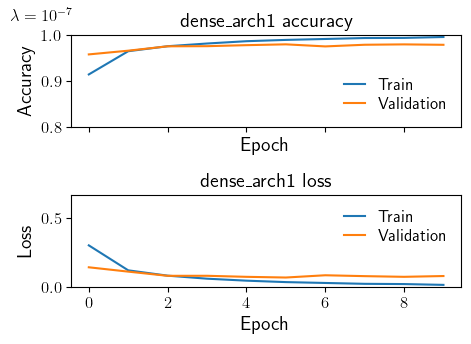

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 200)               157000    
                                                                 
 activation_78 (Activation)  (None, 200)               0         
                                                                 
 dense_79 (Dense)            (None, 100)               20100     
                                                                 
 activation_79 (Activation)  (None, 100)               0         
                                                                 
 dense_80 (Dense)            (None, 10)                1010      
                                                                 
 activation_80 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


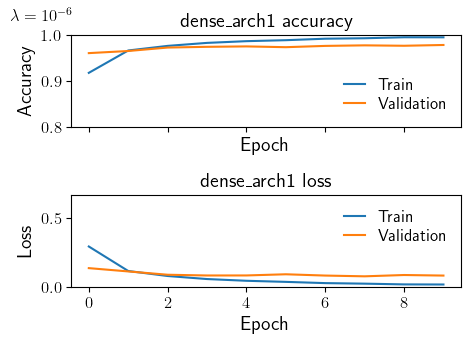

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 200)               157000    
                                                                 
 activation_81 (Activation)  (None, 200)               0         
                                                                 
 dense_82 (Dense)            (None, 100)               20100     
                                                                 
 activation_82 (Activation)  (None, 100)               0         
                                                                 
 dense_83 (Dense)            (None, 10)                1010      
                                                                 
 activation_83 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


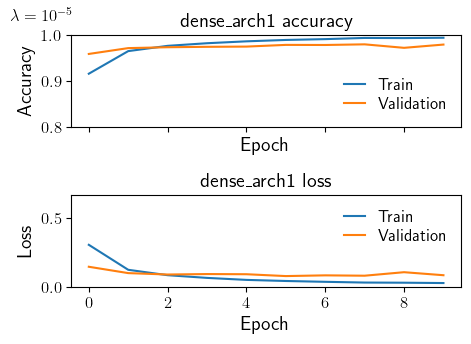

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 200)               157000    
                                                                 
 activation_84 (Activation)  (None, 200)               0         
                                                                 
 dense_85 (Dense)            (None, 100)               20100     
                                                                 
 activation_85 (Activation)  (None, 100)               0         
                                                                 
 dense_86 (Dense)            (None, 10)                1010      
                                                                 
 activation_86 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


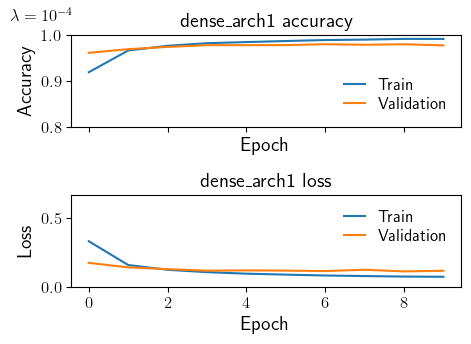

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 200)               157000    
                                                                 
 activation_87 (Activation)  (None, 200)               0         
                                                                 
 dense_88 (Dense)            (None, 100)               20100     
                                                                 
 activation_88 (Activation)  (None, 100)               0         
                                                                 
 dense_89 (Dense)            (None, 10)                1010      
                                                                 
 activation_89 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


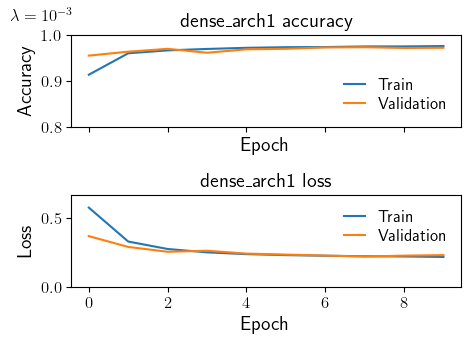

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 200)               157000    
                                                                 
 activation_90 (Activation)  (None, 200)               0         
                                                                 
 dense_91 (Dense)            (None, 100)               20100     
                                                                 
 activation_91 (Activation)  (None, 100)               0         
                                                                 
 dense_92 (Dense)            (None, 10)                1010      
                                                                 
 activation_92 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


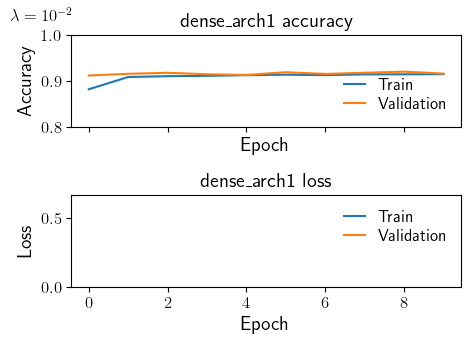

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 200)               157000    
                                                                 
 activation_93 (Activation)  (None, 200)               0         
                                                                 
 dense_94 (Dense)            (None, 100)               20100     
                                                                 
 activation_94 (Activation)  (None, 100)               0         
                                                                 
 dense_95 (Dense)            (None, 10)                1010      
                                                                 
 activation_95 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


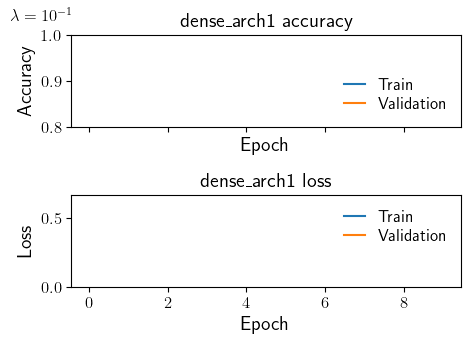

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 200)               157000    
                                                                 
 activation_96 (Activation)  (None, 200)               0         
                                                                 
 dense_97 (Dense)            (None, 100)               20100     
                                                                 
 activation_97 (Activation)  (None, 100)               0         
                                                                 
 dense_98 (Dense)            (None, 10)                1010      
                                                                 
 activation_98 (Activation)  (None, 10)                0         
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 17

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


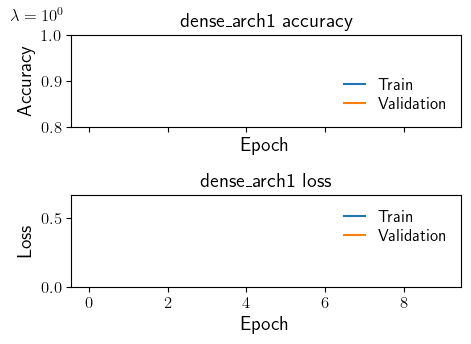

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 200)               157000    
                                                                 
 activation_99 (Activation)  (None, 200)               0         
                                                                 
 dense_100 (Dense)           (None, 100)               20100     
                                                                 
 activation_100 (Activation  (None, 100)               0         
 )                                                               
                                                                 
 dense_101 (Dense)           (None, 10)                1010      
                                                                 
 activation_101 (Activation  (None, 10)                0         
 )                                                   

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


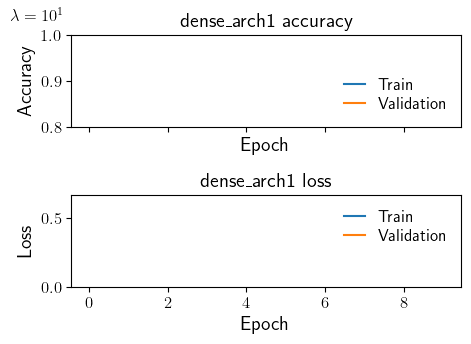

In [10]:
model_name = 'dense_arch1'
cwd = os.getcwd()

if os.path.isfile(os.path.join(cwd, 'exercise/1.4', f'{model_name}_reg_stats.pkl')):
    df_reg = pd.read_pickle(os.path.join(cwd, 'exercise/1.4', f'{model_name}_reg_stats.pkl'))
else:
    cols = {'lambda': int, 'n_params': int, 'train_accuracy': float,
            'train_loss': float, 'validation_accuracy': float, 
            'validation_loss': float}
    df_reg = pd.DataFrame({c: pd.Series(dtype=t) for c, t in cols.items()})

    for L in (10.0 ** np.arange(-10, 2, dtype=int)):
        model, history = main(model_name, regularization=L, path='exercise/1.4')
        df_reg.loc[len(df_reg)] = [
            L,
            sum(K.count_params(p) for p in model.trainable_weights)
            + sum(K.count_params(p) for p in model.non_trainable_weights),
            history.history['accuracy'][-1], 
            history.history['loss'][-1],
            history.history['val_accuracy'][-1], 
            history.history['val_loss'][-1]
        ]
    df_reg.to_pickle(os.path.join(cwd, 'exercise/1.4', f'{model_name}_reg_stats.pkl'))

In [11]:
df_reg

,lambda,n_params,train_accuracy,train_loss,validation_accuracy,validation_loss
0,1.000000e-10,178110.0,0.995783,0.014175,0.9782,0.074992
1,1.000000e-09,178110.0,0.995150,0.015210,0.9783,0.076253
2,1.000000e-08,178110.0,0.995500,0.014145,0.9794,0.076863
3,1.000000e-07,178110.0,0.995850,0.013534,0.9789,0.077687
4,1.000000e-06,178110.0,0.995200,0.016277,0.9785,0.081031
5,1.000000e-05,178110.0,0.994250,0.026826,0.9794,0.083604
6,1.000000e-04,178110.0,0.991650,0.072291,0.9776,0.116129
7,1.000000e-03,178110.0,0.976200,0.216066,0.9724,0.229389
8,1.000000e-02,178110.0,0.915000,0.762178,0.9162,0.746502
9,1.000000e-01,178110.0,0.580433,2.249458,0.5949,2.228811


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 47)                36895     
                                                                 
 activation_102 (Activation  (None, 47)                0         
 )                                                               
                                                                 
 dense_103 (Dense)           (None, 25)                1200      
                                                                 
 activation_103 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_104 (Dense)           (None, 10)                260       
                                                                 
 activation_104 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


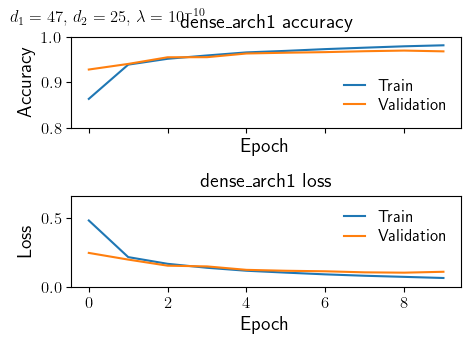

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 47)                36895     
                                                                 
 activation_105 (Activation  (None, 47)                0         
 )                                                               
                                                                 
 dense_106 (Dense)           (None, 25)                1200      
                                                                 
 activation_106 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_107 (Dense)           (None, 10)                260       
                                                                 
 activation_107 (Activation  (None, 10)              

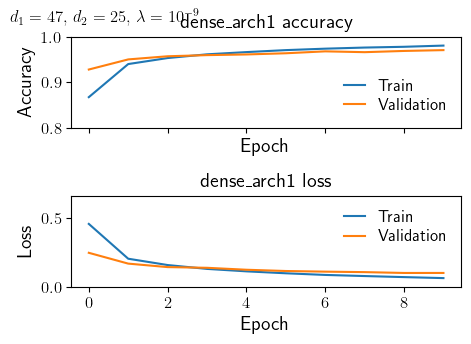

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 47)                36895     
                                                                 
 activation_108 (Activation  (None, 47)                0         
 )                                                               
                                                                 
 dense_109 (Dense)           (None, 25)                1200      
                                                                 
 activation_109 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_110 (Dense)           (None, 10)                260       
                                                                 
 activation_110 (Activation  (None, 10)              

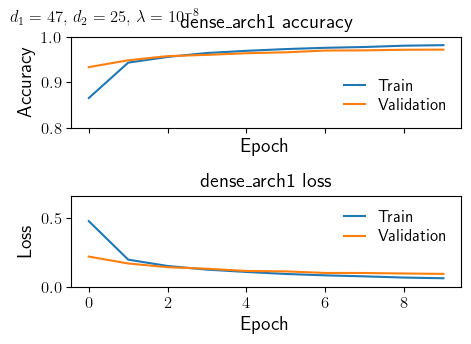

In [12]:
for L in (10.0 ** np.arange(-10, -7, dtype=int)):
    main(model_name, regularization=L, n1=47, n2=25, path='exercise/1.3')

### 1.5 Activations

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 200)               157000    
                                                                 
 activation_111 (Activation  (None, 200)               0         
 )                                                               
                                                                 
 dense_112 (Dense)           (None, 100)               20100     
                                                                 
 activation_112 (Activation  (None, 100)               0         
 )                                                               
                                                                 
 dense_113 (Dense)           (None, 10)                1010      
                                                                 
 activation_113 (Activation  (None, 10)              

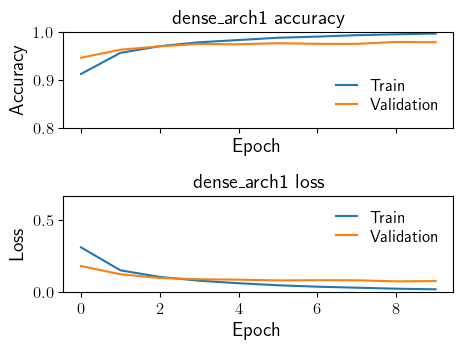

In [13]:
model, history = main(model_name, activation="tanh", path='exercise/1.5')

### 1.6 Different Architectures

### 1.7 Convolutional Neural Nets

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation_114 (Activation  (None, 28, 28, 20)        0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        1810      
                                                                 
 activation_115 (Activation  (None, 14, 14, 10)        0         
 )                                                               
                                                     

2023-11-14 01:43:08.480753: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


469/469 [==============================] - 7s 8ms/step - loss: 0.4294 - accuracy: 0.8740 - val_loss: 0.1368 - val_accuracy: 0.9585
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1137 - accuracy: 0.9663 - val_loss: 0.0789 - val_accuracy: 0.9766
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0793 - accuracy: 0.9761 - val_loss: 0.0596 - val_accuracy: 0.9822
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0653 - accuracy: 0.9801 - val_loss: 0.0512 - val_accuracy: 0.9838
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0562 - accuracy: 0.9825 - val_loss: 0.0466 - val_accuracy: 0.9848
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0507 - accuracy: 0.9842 - val_loss: 0.0454 - val_accuracy: 0.9862
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0492 - val_accuracy: 0.9835
Epoch 8/10
469/46

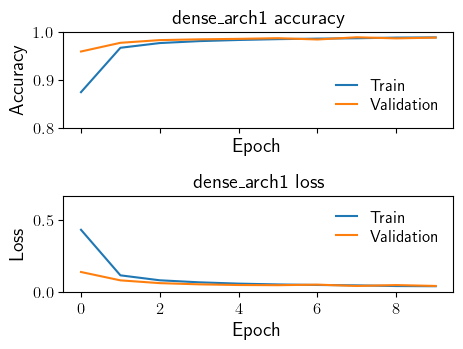

(<keras.src.engine.sequential.Sequential at 0x7f28a0f1d6d0>,
 <keras.src.callbacks.History at 0x7f28a4ac2dd0>)

In [14]:
main(model_name, False, REGULARIZATION, path='exercise/1.7')

## Evaluate

Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to load and evaluate a saved Keras model's performance on the MNIST dataset of handwritten images. Prints out training and validation loss and accuracy, and also visualizes validation images the model got wrong.

In [15]:
## Get data in a format compatible with the neural net we want to evaluate
def get_data(model):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Determine input shape that the model given should take
    input_shape = model.get_layer(index=0).input_shape

    # Normalize data to be in [0, 1] and reshape appropriately
    X_train = X_train.reshape(-1, *input_shape[1:]) / 255
    X_test = X_test.reshape(-1, *input_shape[1:]) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


def main(file_prefix):
    model_name = file_prefix

    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': 
        cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', f'{model_name}.h5')
    model_json_fname = os.path.join(cwd, 'model', f'{model_name}.json')

    # Load model and its weights
    with open(model_json_fname, 'r') as f: 
        model_json = f.read()
    model = model_from_json(model_json)
    model.load_weights(model_weights_fname)

    # Get MNIST data shaped appropriately for the model
    (X_train, y_train), (X_test, y_test) = get_data(model)

    # Compile model and evaluate its performance on training and test data
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

    score = model.evaluate(X_train, y_train, verbose=0)
    print()
    print('Training loss:', score[0])
    print('Training accuracy:', score[1])

    score = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

    # Determine validation examples that the model got wrong
    y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
    y_true = np.array([np.argmax(y) for y in y_test])
    mistakes = (y_pred != y_true)
    X_wrong = X_test[mistakes].reshape(-1, 28, 28) # To visualize properly
    y_wrong = y_pred[mistakes]
    y_right = y_true[mistakes]

    # Visualize some of the validation examples the model got wrong
    nrow, ncol = 3, 5
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            ax = axs[i][j]
            ax.imshow(X_wrong[idx], cmap='gray')
            ax.set_title(f'Pred: {y_wrong[idx]}\nTrue: {y_right[idx]}')
            ax.axis('off')
    fig.tight_layout(pad=2.5)
    plt.suptitle(f'Validation Images {model_name} Got Wrong')
    plt.savefig(os.path.join(cwd, 'img', f'{model_name}_mistakes.png'))
    plt.show()


Training loss: 0.006910241208970547
Training accuracy: 0.9981666803359985

Validation loss: 0.07161609083414078
Validation accuracy: 0.9814000129699707
313/313 [==============================] - 1s 2ms/step


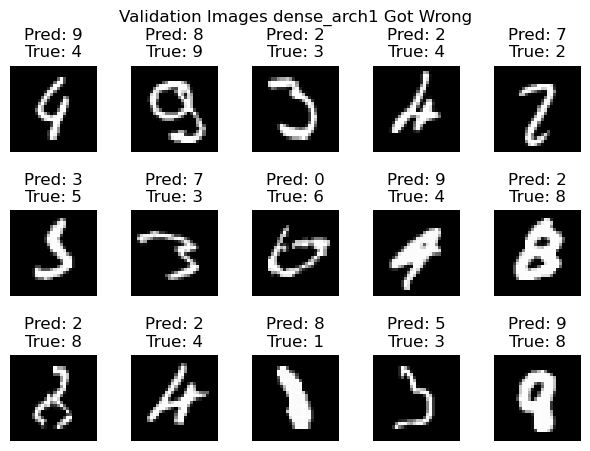

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)
main(FILE_PREFIX)